In [1]:
# pip install matplotlib h5py scipy seaborn scikit-learn --no-index

In [2]:
import os, sys
from pathlib import Path
project_root = Path.cwd().parent 
# sys.path.append(str(project_##root))

BASE_DIR = Path.cwd().parent  # go up one level

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from matplotlib.colors import Normalize
# Import the analysis module
from mirrored_langevin_rnn.utils.data_pipeline.threshold_sweep_analysis import (
    load_threshold_batch_files,
    plot_threshold_heatmap,
    merge_threshold_batches
)

## Configuration

Set up the experiment configuration, including file patterns and parameters.

In [4]:
poisson_out_dirs = [
    BASE_DIR / "data" / "threshold_sweep" / "poisson" / "auc" / "affinity_dense_gamma",
    BASE_DIR / "data" / "threshold_sweep" / "poisson" / "auc" / "affinity_sparse_gamma_sparsity_0.10",
    BASE_DIR / "data" / "threshold_sweep" / "poisson" / "auc" / "affinity_sparse_binary_sparsity_0.10",
]
slam_ber_out_dirs = [
    BASE_DIR / "data" / "threshold_sweep" / "slam" / "auc" / "bernoulli" / "affinity_dense_gamma",
    BASE_DIR / "data" / "threshold_sweep" / "slam" / "auc" / "bernoulli" / "affinity_sparse_gamma_sparsity_0.10",
    BASE_DIR / "data" / "threshold_sweep" / "slam" / "auc" / "bernoulli" / "affinity_sparse_binary_sparsity_0.10",
]
slam_kum_out_dirs = [
    BASE_DIR / "data" / "threshold_sweep" / "slam" / "auc" / "kumaraswamy" / "affinity_dense_gamma",
    BASE_DIR / "data" / "threshold_sweep" / "slam" / "auc" / "kumaraswamy" / "affinity_sparse_gamma_sparsity_0.10",
    BASE_DIR / "data" / "threshold_sweep" / "slam" / "auc" / "kumaraswamy" / "affinity_sparse_binary_sparsity_0.10",
]

plot_combination = [
    ("poisson_auc_binary_threshold_results_batch*.h5", poisson_out_dirs),
    ("slam_auc_bernoulli_threshold_results_batch*.h5", slam_ber_out_dirs),
    ("slam_auc_kumaraswamy_threshold_results_batch*.h5", slam_kum_out_dirs),
]

# FILE_PATTERN = "slam_auc_bernoulli_threshold_results_batch*.h5"
# FILE_PATTERN = "slam_auc_kumaraswamy_threshold_results_batch*.h5"
# FILE_PATTERN = "poisson_rank_binary_threshold_results_batch*.h5"
# FILE_PATTERN = "poisson_rank_threshold_results_batch*.h5"

In [5]:
BATCH_SIZE = 1  

In [6]:
hide_label = False
# Save SVG to the figures directory
figures_dir = BASE_DIR / "figures" / "threshold_sweep" / "auc"
if hide_label:
    figures_dir = figures_dir / "labels_hidden"
else:
    figures_dir = figures_dir / "labels_visible"
figures_dir.mkdir(parents=True, exist_ok=True)

## Visualize the Merged Threshold Sweep Results

Now we'll create a heatmap visualization of the merged grid with contour lines.

In [7]:
from pygments import highlight


def create_threshold_heatmap_plot(out_dir, file_pattern, plot_title=None, hide_axis_labels=True):
    """
    Create a threshold heatmap plot for given output directory and file pattern.
    
    Args:
        out_dir: Path to output directory containing batch files
        file_pattern: File pattern to match batch files
        n_odor_values: Number of odor values for grid
        n_sens_values: Number of sensor values for grid
        plot_title: Optional title for the plot
        hide_axis_labels: Whether to hide axis labels (default: True)
    
    Returns:
        tuple: (fig, ax, merged_grid, merged_path)
    """
    separatedColor = "#D95319"           # SLAM
    circuitColor = "#E13960"
    highlight_color = circuitColor
    
    grids, files, n_sens_values, n_odor_values = load_threshold_batch_files(
        out_dir,
        pattern=file_pattern
    )
    
    # Merge the grids into a complete grid using the first valid value at each position
    merged_grid, merged_path = merge_threshold_batches(
        out_dir, 
        pattern=file_pattern,
        output_file="threshold_results_merged.h5",
        merge_method="first_valid"  # Use first valid value (alternatives: "max", "min", "mean")
    )

    print(f"Processing: {out_dir}")
    print(f"Pattern: {file_pattern}")
    print(f"Merged grid shape: {merged_grid.shape}")
    print(f"Saved to: {merged_path}")

    # Count non-NaN values to check grid completeness
    non_nan_count = np.count_nonzero(~np.isnan(merged_grid))
    total_cells = merged_grid.size
    print(f"Grid completeness: {non_nan_count}/{total_cells} cells filled ({non_nan_count/total_cells:.1%})")

    # Create a figure and plot the heatmap
    fig, ax = plot_threshold_heatmap(
        merged_grid,
        n_odor_values,
        n_sens_values,
        figsize=(7,6),
        cmap="Blues",
        sigma=1,  # Gaussian smoothing parameter
        contour_levels = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        highlight_level=20,
        annot=False,
        highlight_color=highlight_color  # Use the provided highlight color
    )
    ax.set_xlim([1000, 16000])
    
    
    # Configure colorbar
    norm = Normalize(vmin=5, vmax=100)
    cbar = fig.colorbar(ax.collections[0], ax=ax, shrink=0.9, aspect=9)
    cbar.mappable.set_norm(norm)
    cbar.set_ticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    cbar.ax.tick_params(width=0)
    cbar.set_ticklabels(["", '20', "", '40', "", '60', "", '80', "", '100+'], fontsize=16)
    cbar.outline.set_linewidth(2)
    
    # Add contour lines to colorbar
    contour_levels = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    for level in contour_levels:
        if level == 20:
            cbar.ax.axhline(level, xmin=0.66, xmax=1, color=highlight_color, linestyle='solid', linewidth=3)
        else:
            cbar.ax.axhline(level, xmin=0.66, xmax=1, color='black', linestyle='solid', linewidth=2)
    
    cbar.ax.set_visible(True)
    
    # Apply hide_labels if requested
    if hide_axis_labels:
        ax.tick_params(labelbottom=False, labelleft=False)
        cbar.ax.set_visible(False)
    
    return fig, ax, merged_grid, merged_path

## Generate All Threshold Heatmap Plots

The following code will automatically generate threshold heatmap plots for all combinations defined in `plot_combination`. This includes:

- **3 Poisson model configurations**: dense gamma, sparse binary, sparse gamma
- **3 SLAM Bernoulli configurations**: dense gamma, sparse gamma, sparse binary  
- **3 SLAM Kumaraswamy configurations**: dense gamma, sparse binary, sparse gamma

Each plot will be saved with a descriptive filename and displayed in the notebook. The function `create_threshold_heatmap_plot()` handles the data loading, merging, visualization, and colorbar configuration for each combination.


Processing file pattern: poisson_auc_binary_threshold_results_batch*.h5
Processing: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/poisson/auc/affinity_dense_gamma
Pattern: poisson_auc_binary_threshold_results_batch*.h5
Merged grid shape: (15, 16)
Saved to: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/poisson/auc/affinity_dense_gamma/threshold_results_merged.h5
Grid completeness: 240/240 cells filled (100.0%)


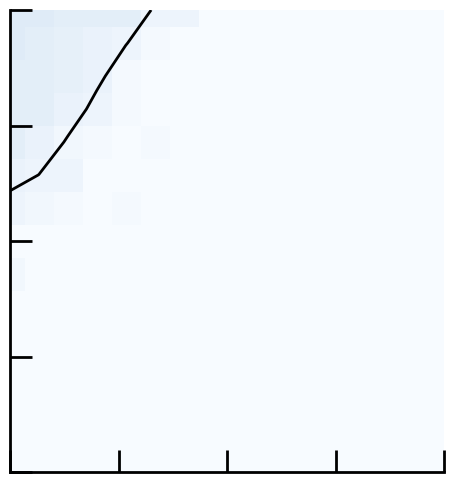


Completed 1/3 for pattern poisson_auc_binary_threshold_results_batch*.h5
Processing: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/poisson/auc/affinity_sparse_gamma_sparsity_0.10
Pattern: poisson_auc_binary_threshold_results_batch*.h5
Merged grid shape: (15, 16)
Saved to: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/poisson/auc/affinity_sparse_gamma_sparsity_0.10/threshold_results_merged.h5
Grid completeness: 240/240 cells filled (100.0%)


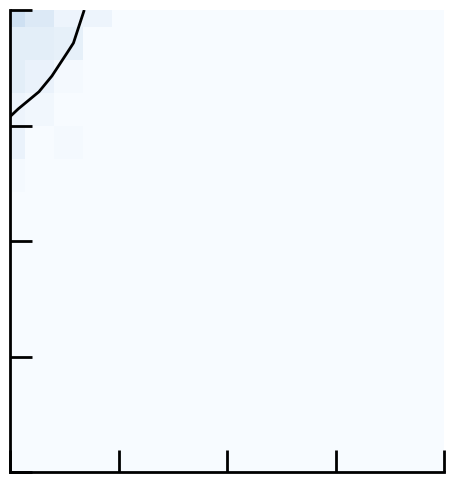


Completed 2/3 for pattern poisson_auc_binary_threshold_results_batch*.h5
Processing: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/poisson/auc/affinity_sparse_binary_sparsity_0.10
Pattern: poisson_auc_binary_threshold_results_batch*.h5
Merged grid shape: (15, 16)
Saved to: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/poisson/auc/affinity_sparse_binary_sparsity_0.10/threshold_results_merged.h5
Grid completeness: 240/240 cells filled (100.0%)


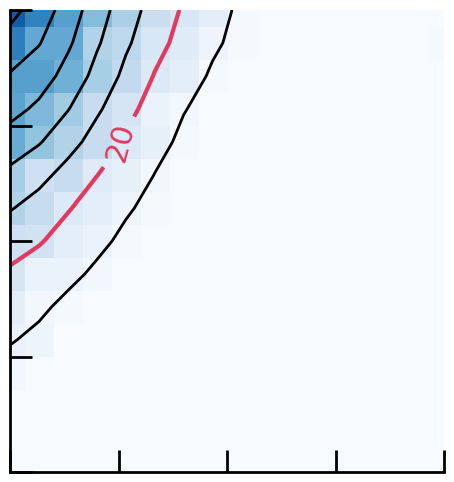


Completed 3/3 for pattern poisson_auc_binary_threshold_results_batch*.h5

Processing file pattern: slam_auc_bernoulli_threshold_results_batch*.h5
Processing: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/slam/auc/bernoulli/affinity_dense_gamma
Pattern: slam_auc_bernoulli_threshold_results_batch*.h5
Merged grid shape: (15, 16)
Saved to: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/slam/auc/bernoulli/affinity_dense_gamma/threshold_results_merged.h5
Grid completeness: 240/240 cells filled (100.0%)


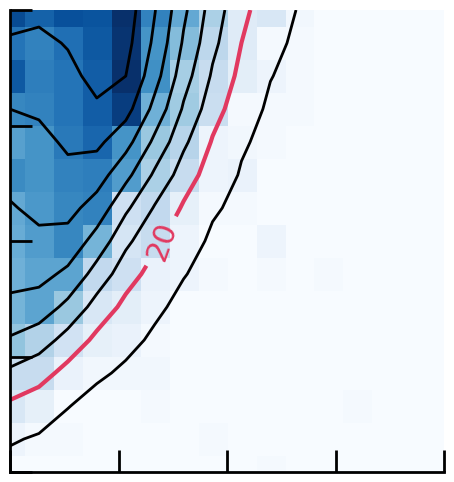


Completed 1/3 for pattern slam_auc_bernoulli_threshold_results_batch*.h5
Processing: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/slam/auc/bernoulli/affinity_sparse_gamma_sparsity_0.10
Pattern: slam_auc_bernoulli_threshold_results_batch*.h5
Merged grid shape: (15, 16)
Saved to: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/slam/auc/bernoulli/affinity_sparse_gamma_sparsity_0.10/threshold_results_merged.h5
Grid completeness: 240/240 cells filled (100.0%)


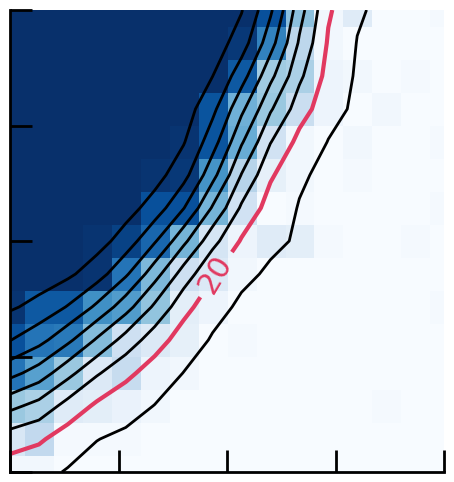


Completed 2/3 for pattern slam_auc_bernoulli_threshold_results_batch*.h5
Processing: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/slam/auc/bernoulli/affinity_sparse_binary_sparsity_0.10
Pattern: slam_auc_bernoulli_threshold_results_batch*.h5
Merged grid shape: (15, 16)
Saved to: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/slam/auc/bernoulli/affinity_sparse_binary_sparsity_0.10/threshold_results_merged.h5
Grid completeness: 240/240 cells filled (100.0%)


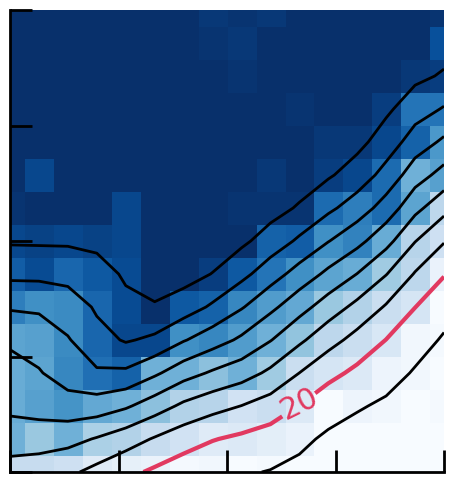


Completed 3/3 for pattern slam_auc_bernoulli_threshold_results_batch*.h5

Processing file pattern: slam_auc_kumaraswamy_threshold_results_batch*.h5
Processing: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/slam/auc/kumaraswamy/affinity_dense_gamma
Pattern: slam_auc_kumaraswamy_threshold_results_batch*.h5
Merged grid shape: (15, 16)
Saved to: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/slam/auc/kumaraswamy/affinity_dense_gamma/threshold_results_merged.h5
Grid completeness: 240/240 cells filled (100.0%)


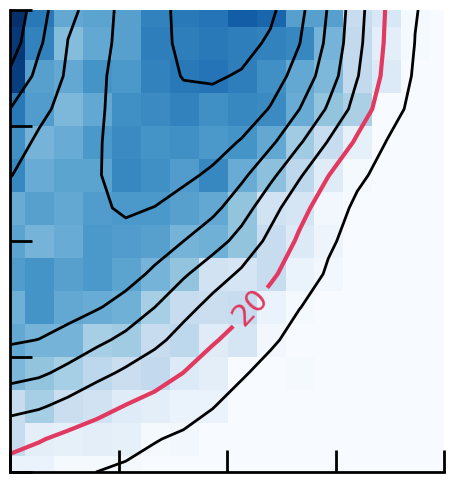


Completed 1/3 for pattern slam_auc_kumaraswamy_threshold_results_batch*.h5
Processing: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/slam/auc/kumaraswamy/affinity_sparse_gamma_sparsity_0.10
Pattern: slam_auc_kumaraswamy_threshold_results_batch*.h5
Merged grid shape: (15, 16)
Saved to: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/slam/auc/kumaraswamy/affinity_sparse_gamma_sparsity_0.10/threshold_results_merged.h5
Grid completeness: 240/240 cells filled (100.0%)


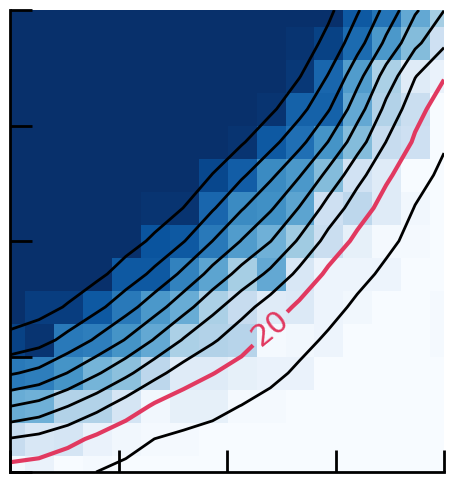


Completed 2/3 for pattern slam_auc_kumaraswamy_threshold_results_batch*.h5
Processing: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/slam/auc/kumaraswamy/affinity_sparse_binary_sparsity_0.10
Pattern: slam_auc_kumaraswamy_threshold_results_batch*.h5
Merged grid shape: (15, 16)
Saved to: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/slam/auc/kumaraswamy/affinity_sparse_binary_sparsity_0.10/threshold_results_merged.h5
Grid completeness: 240/240 cells filled (100.0%)


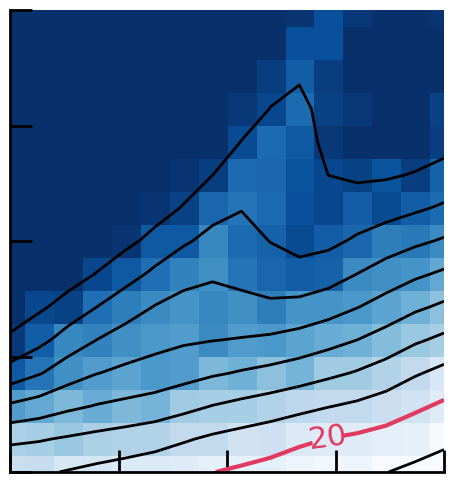


Completed 3/3 for pattern slam_auc_kumaraswamy_threshold_results_batch*.h5

All plots completed! Generated 9 plots total.


In [8]:
# Generate plots for all combinations
plot_results = []

for file_pattern, out_dirs in plot_combination:
    print(f"\n{'='*60}")
    print(f"Processing file pattern: {file_pattern}")
    print(f"{'='*60}")
    
    for i, out_dir in enumerate(out_dirs):
        # Use out_dir as the title
        plot_title = str(out_dir)
        out_dir = Path(out_dir) 
        fig, ax, merged_grid, merged_path = create_threshold_heatmap_plot(
            out_dir, 
            file_pattern, 
            plot_title=plot_title,
            hide_axis_labels=True 
        )
        
        # Create filename based on directory structure
        dir_parts = str(out_dir).split('/')
        plot_filename_base = f"threshold_heatmap_{file_pattern.replace('*', '').replace('.h5', '')}_{dir_parts[-1]}"
        
        # Save PNG to the output directory
        # plt.savefig(out_dir / f"{plot_filename_base}.png", dpi=300, bbox_inches="tight")
        
        plt.savefig(figures_dir / f"{plot_filename_base}.svg", bbox_inches="tight")
        
        # Store results for later analysis if needed
        plot_results.append({
            'out_dir': out_dir,
            'file_pattern': file_pattern,
            'plot_title': plot_title,
            'merged_grid': merged_grid,
            'merged_path': merged_path,
            'plot_filename': plot_filename_base
        })
        
        plt.show()
        print(f"\nCompleted {i+1}/{len(out_dirs)} for pattern {file_pattern}")

print(f"\n{'='*60}")
print(f"All plots completed! Generated {len(plot_results)} plots total.")
print(f"{'='*60}")